In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels
import os
import sys
from os import listdir
from os.path import isfile, join
import functools 
from matplotlib_venn import venn3
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 600

In [2]:
expression_file = "/data8t/mtx/scSNV/dataset_v2/GSE57872/data/quantification_stats/gene_expression_matrix/gene_expression_matrix_cpm.csv"
exp_profile = pd.read_csv(expression_file,index_col=0)
reads_file = "/data8t/mtx/scSNV/dataset_v2/GSE57872/data/quantification_stats/gene_expression_matrix/gene_expression_matrix.csv"
reads_profile = pd.read_csv(reads_file,index_col=0)

In [67]:
pvalue_cellline = pd.read_csv('cellline.csv',index_col=0)
pvalue_patients = pd.read_csv('patients.csv',index_col=0)
pvalue_all = pd.read_csv('all_gene_snv.csv',index_col=0)

gene_patients = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_final_cpm_MGH.csv', index_col=0)
snv_patients = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_final_snv_MGH.csv', index_col=0)

gene_cellline = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_final_cpm_CSC.csv', index_col=0)
snv_cellline = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_final_snv_CSC.csv', index_col=0)

gene_all = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_cpm_final_1000genes.csv', index_col=0)
snv_all = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_snv_on_filtered_genes_pass_40_cells.csv', index_col=0)


label_all = pd.read_csv('/data8t/mtx/scSNV/dataset_v2/GSE57872/data/processed_profile/GSE57872_cellline_patient_label.csv', index_col=0)


# Filter out all-non-zero genes

In [70]:
all_nonzero_gene_all = (gene_all > 0).sum(axis = 1)[(gene_all > 0).sum(axis = 1) == gene_all.shape[1]].index.values
all_nonzero_gene_cellline = (gene_cellline > 0).sum(axis = 1)[(gene_cellline > 0).sum(axis = 1) == gene_cellline.shape[1]].index.values
all_nonzero_gene_patients = (gene_patients > 0).sum(axis = 1)[(gene_patients > 0).sum(axis = 1) == gene_patients.shape[1]].index.values

In [72]:
all_nonzero_gene_cellline

array(['ENSG00000079459.8', 'ENSG00000125148.6'], dtype=object)

In [81]:
gene_all_filtered = gene_all.loc[~gene_all.index.isin(all_nonzero_gene_all),]
gene_cellline_filtered = gene_cellline.loc[~gene_cellline.index.isin(all_nonzero_gene_cellline),]
gene_patients_filtered = gene_patients.loc[~gene_patients.index.isin(all_nonzero_gene_patients),]
pvalue_all_filtered = pvalue_all.loc[~pvalue_all.index.isin(all_nonzero_gene_all),]
pvalue_cellline_filtered = pvalue_cellline.loc[~pvalue_cellline.index.isin(all_nonzero_gene_cellline),]
pvalue_patients_filtered = pvalue_patients.loc[~pvalue_patients.index.isin(all_nonzero_gene_patients),]

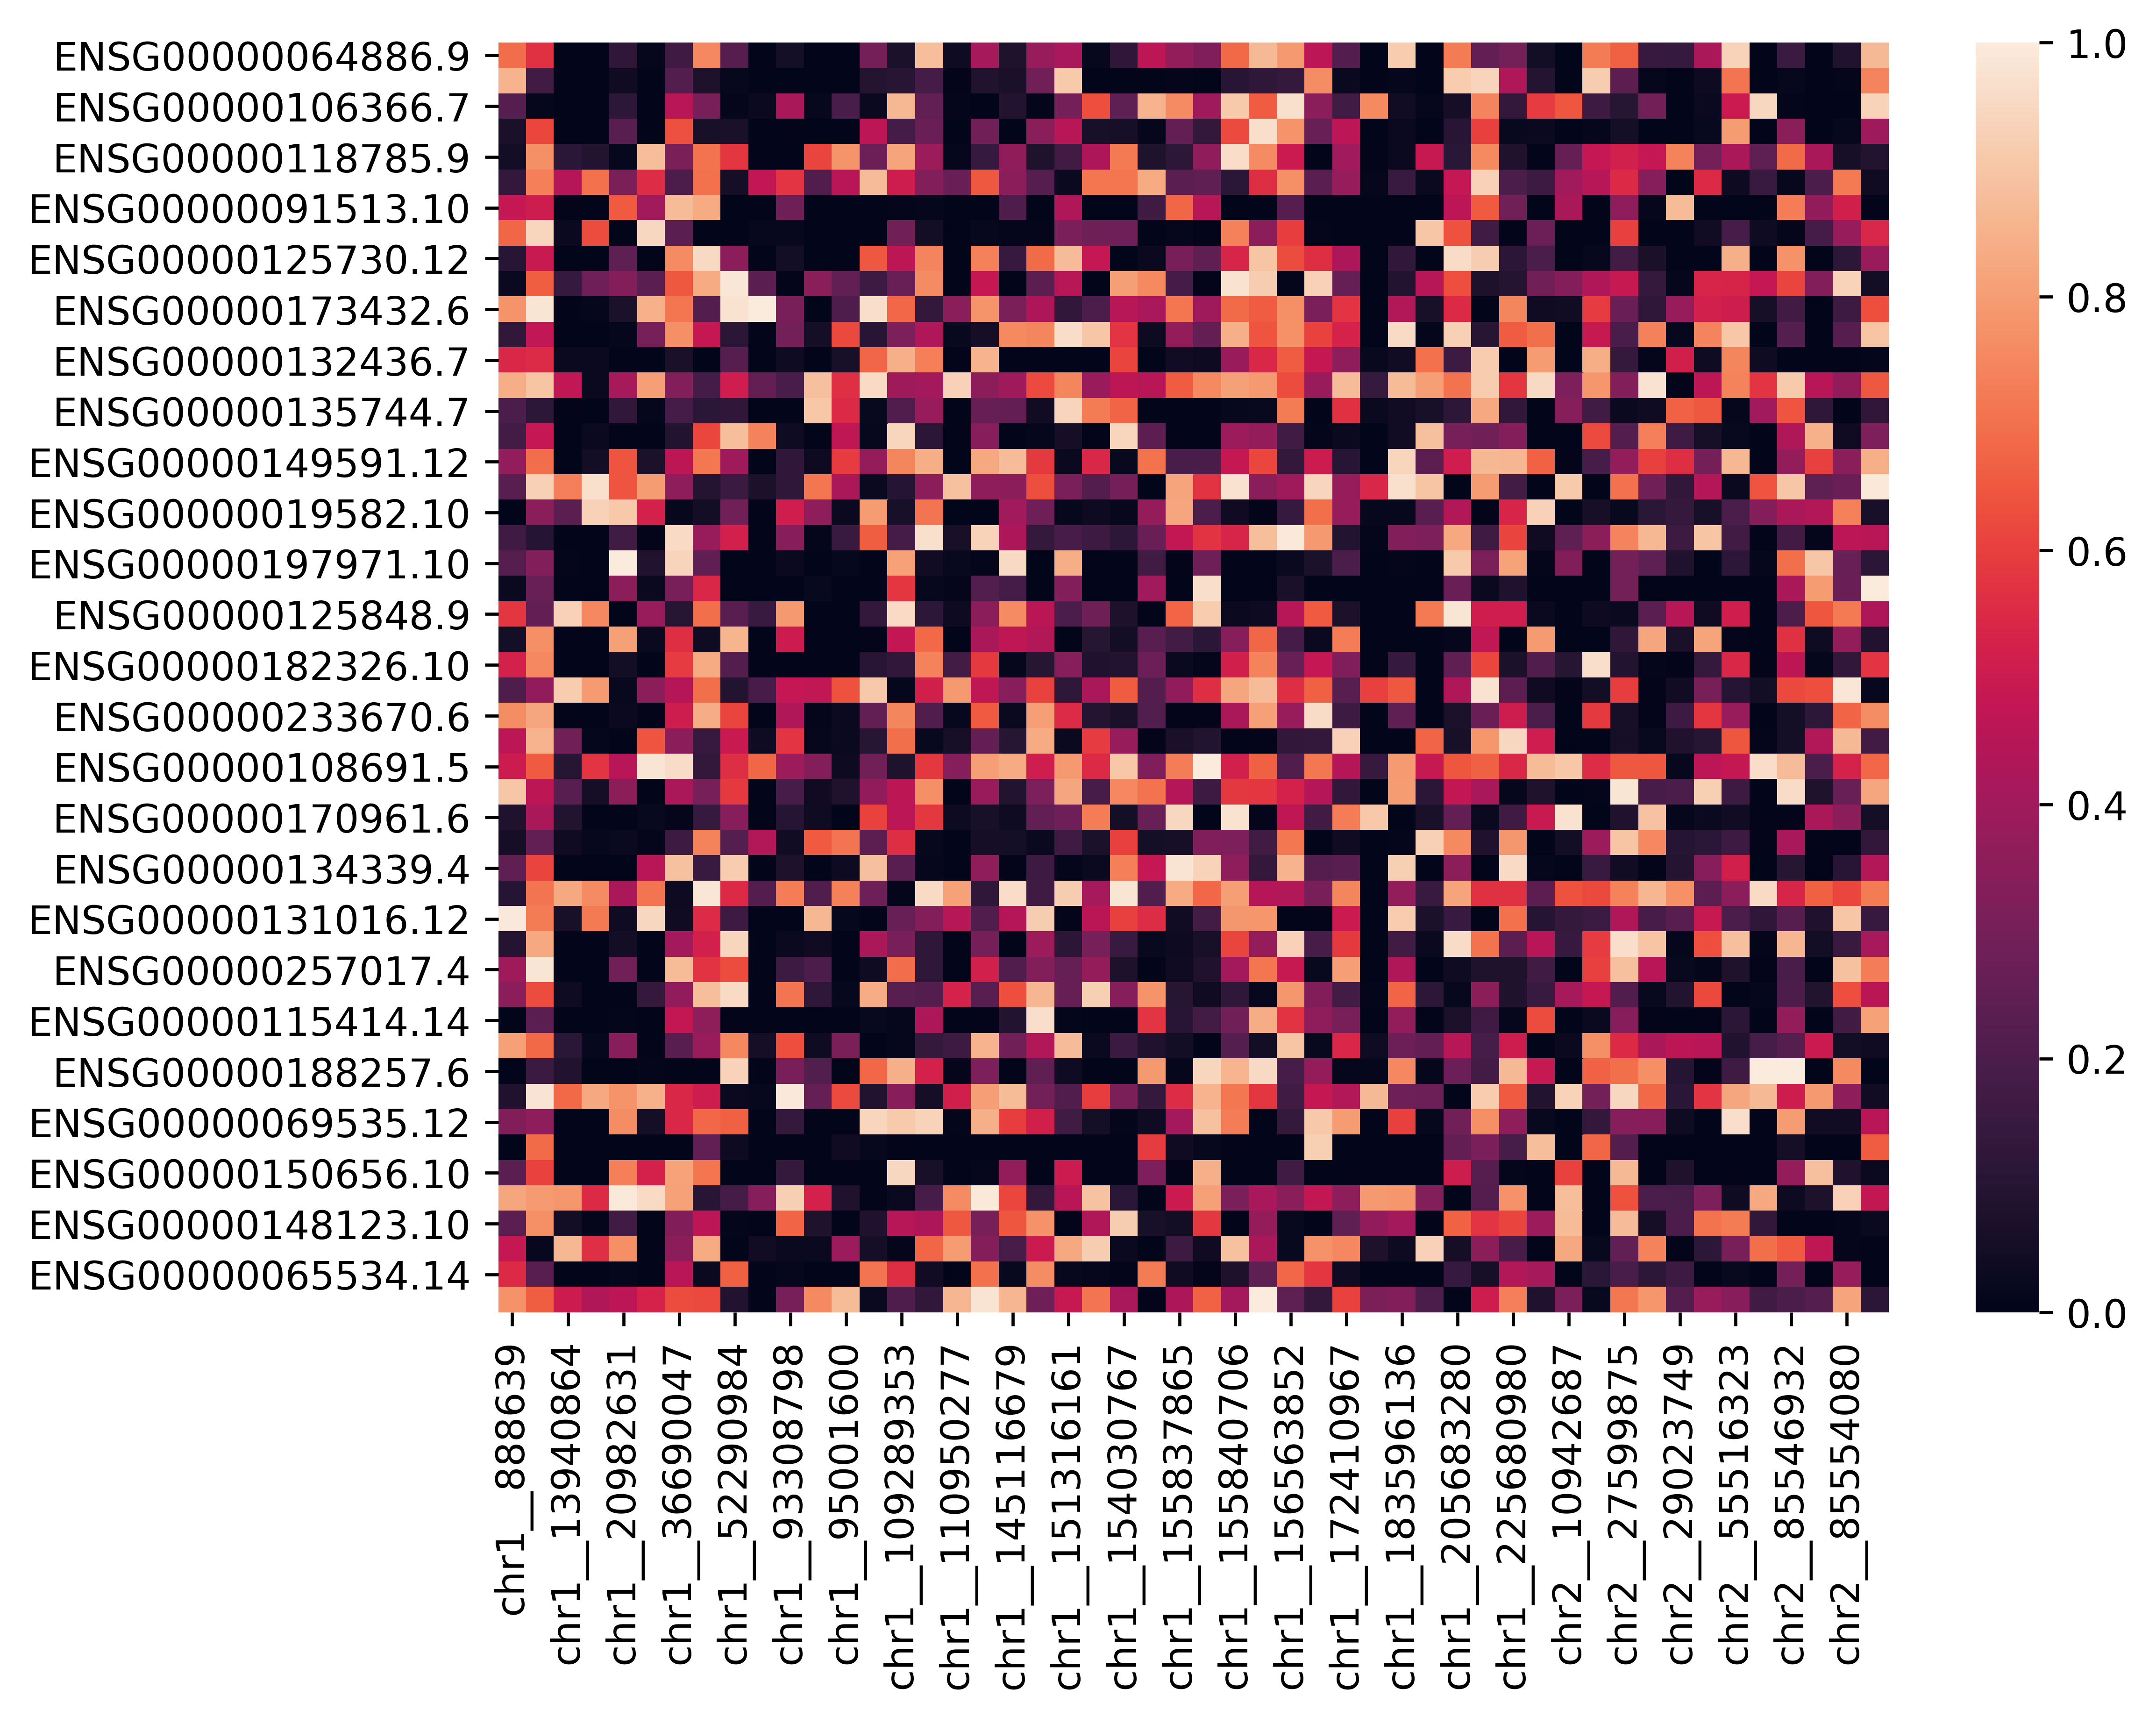

In [82]:
sns.heatmap(pvalue_all.iloc[:50,:50])

# Filter out too-many-zeros genes

In [83]:
gene_all_filtered = gene_all_filtered.loc[(gene_all_filtered > 2).sum(axis=1)[(gene_all_filtered > 2).sum(axis=1) > 30].index.values,]
gene_patients_filtered = gene_patients_filtered.loc[(gene_patients_filtered > 2).sum(axis=1)[(gene_patients_filtered > 2).sum(axis=1) > 20].index.values,]
gene_cellline_filtered = gene_cellline_filtered.loc[(gene_cellline_filtered > 2).sum(axis=1)[(gene_cellline_filtered > 2).sum(axis=1) > 20].index.values,]

In [84]:
pvalue_all_filtered = pvalue_all_filtered.loc[gene_all_filtered.index.values, ]
pvalue_cellline_filtered = pvalue_cellline_filtered.loc[gene_cellline_filtered.index.values, ]
pvalue_patients_filtered = pvalue_patients_filtered.loc[gene_patients_filtered.index.values, ]

# Select SNVs

In [86]:
def select_snv(df,threshold = 20):
    # input is a snv matrix, snv*samples
    tmp_df = df.copy(deep=True)
    snv_yes = set((tmp_df == 1).sum(axis=1)[(tmp_df == 1).sum(axis=1) >= threshold].index.values)
    snv_no = set((tmp_df == 0).sum(axis=1)[(tmp_df == 0).sum(axis=1) >= threshold].index.values)
    snv_valid = snv_yes.intersection(snv_no)
    #tmp_df = tmp_df.loc[snv_valid,:]
    return snv_valid

In [87]:
snv_valid_all = select_snv(snv_all)
snv_valid_cellline = select_snv(snv_cellline)
snv_valid_patients = select_snv(snv_patients)

In [88]:
len(snv_valid_all)

3513

In [89]:
len(snv_valid_cellline)

1846

In [90]:
len(snv_valid_patients)

3231

In [91]:
pvalue_all_filtered = pvalue_all_filtered.loc[:,snv_valid_all]
pvalue_cellline_filtered = pvalue_cellline_filtered.loc[:,snv_valid_cellline]
pvalue_patients_filtered = pvalue_patients_filtered.loc[:,snv_valid_patients]

In [92]:
pvalue_all_filtered

,chr6__3015790,chr16__8738427,chrX__53835046,chr9__119462112,chr6__111695073,chr1__156025096,chr7__55243809,chr1__179887788,chr21__17635519,chrM__14906,...,chr3__3189279,chr5__112356649,chr7__13935307,chr7__127721507,chr11__74210137,chr16__11945394,chr6__10982973,chr14__76663938,chr12__32135441,chr8__29927321
ENSG00000064886.9,0.128696,0.927538,0.184159,0.025430,0.119628,7.085681e-05,0.000043,0.158004,0.617400,0.022314,...,0.865398,0.261636,8.993216e-02,0.000297,0.266235,0.573877,0.396669,0.576187,0.668687,0.135665
ENSG00000175899.10,0.054100,0.018966,0.001019,0.006754,0.006553,8.914523e-10,0.001640,0.443250,0.787634,0.000477,...,0.697257,0.000112,1.445865e-04,0.000190,0.081415,0.276499,0.891597,0.213311,0.343497,0.034000
ENSG00000106366.7,0.725094,0.451100,0.049376,0.783591,0.134718,1.816069e-02,0.579695,0.498122,0.686607,0.149939,...,1.000000,0.253761,2.695246e-03,0.839736,0.239240,0.895826,0.170143,0.177531,0.758053,0.832941
ENSG00000112096.12,0.961252,0.466824,0.001727,0.260566,0.307436,2.670240e-07,0.033075,0.204187,0.460508,0.021895,...,0.992291,0.000165,1.505405e-12,0.017103,0.314478,0.548157,0.128311,0.092790,0.434766,0.881540
ENSG00000118785.9,0.059594,0.025514,0.597102,0.073590,0.017845,1.276641e-04,0.000806,0.303942,0.798580,0.000036,...,0.997003,0.383535,1.037039e-01,0.000256,0.164533,0.450297,0.469205,0.859237,0.609351,0.184544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000118194.14,0.026245,0.526590,0.887881,0.949012,0.642336,5.371938e-01,0.426857,0.664608,0.353201,0.484348,...,0.563534,0.011200,9.568727e-03,0.722357,0.305446,0.980545,0.549691,0.004817,0.562851,0.570536
ENSG00000182405.4,0.351065,0.973866,0.778322,0.676608,0.611156,7.178499e-01,0.572457,0.988377,0.016321,0.545104,...,0.803174,0.510679,1.064270e-02,0.548798,0.229404,0.584098,0.217846,0.951161,0.255655,0.886400
ENSG00000172602.5,0.315791,0.654256,0.000292,0.000105,0.070835,2.861753e-02,0.002324,0.163325,0.222393,0.468941,...,0.536855,0.517885,5.583006e-01,0.380917,0.717264,0.947322,0.267114,0.012832,0.647417,0.099310
ENSG00000170385.9,0.024537,0.681194,0.858859,0.556899,0.060520,8.578585e-04,0.809047,0.104168,0.386022,0.209285,...,0.472231,0.918948,2.543170e-01,0.082620,0.297930,0.166616,0.593539,0.099009,0.175858,0.126447


# Adjust p-value

In [93]:
def df2col(df):
    #df is pvalue dataframe
    row_num = df.shape[0]
    col_num = df.shape[1]
    tmp = 0
    tmp_index_list = []
    for i in range(row_num):
        for j in range(col_num):
            tmp = tmp +1
            k = df.index.values[i] + "____" + df.columns.values[j]
            tmp_index_list.append(k)
    df_one_column = pd.DataFrame({'pvalue':df.values.reshape(-1)})
    df_one_column.index = tmp_index_list
    return df_one_column
    

In [94]:
pvalue_all_col = df2col(pvalue_all_filtered)
pvalue_cellline_col = df2col(pvalue_cellline_filtered)
pvalue_patients_col = df2col(pvalue_patients_filtered)
#remove nan value
pvalue_all_col_valid = pvalue_all_col.loc[~pvalue_all_col.isna().pvalue,]
pvalue_cellline_col_valid = pvalue_cellline_col.loc[~pvalue_cellline_col.isna().pvalue,]
pvalue_patients_col_valid = pvalue_patients_col.loc[~pvalue_patients_col.isna().pvalue,]

pvalue_all_adjusted = statsmodels.stats.multitest.multipletests(pvalue_all_col_valid.pvalue.values,alpha=0.05)
pvalue_cellline_adjusted = statsmodels.stats.multitest.multipletests(pvalue_cellline_col_valid.pvalue.values,alpha=0.05)
pvalue_patients_adjusted = statsmodels.stats.multitest.multipletests(pvalue_patients_col_valid.pvalue.values,alpha=0.05)

pvalue_all_col_final = pvalue_all_col_valid.copy(deep=True)
pvalue_all_col_final['pvalue_adj'] = pvalue_all_adjusted[1]

pvalue_cellline_col_final = pvalue_cellline_col_valid.copy(deep=True)
pvalue_cellline_col_final['pvalue_adj'] = pvalue_cellline_adjusted[1]

pvalue_patients_col_final = pvalue_patients_col_valid.copy(deep=True)
pvalue_patients_col_final['pvalue_adj'] = pvalue_patients_adjusted[1]

pair_all = set(pvalue_all_col_final[pvalue_all_col_final['pvalue_adj']<0.01].index.values)
pair_cellline = set(pvalue_cellline_col_final[pvalue_cellline_col_final['pvalue_adj']<0.01].index.values)
pair_patients = set(pvalue_patients_col_final[pvalue_patients_col_final['pvalue_adj']<0.01].index.values)

In [99]:
len(pair_patients)

20058

# Result

In [100]:
# only
only_all = pair_all - pair_cellline - pair_patients 
only_cellline = pair_cellline -  pair_patients - pair_all
only_patients = pair_patients -  pair_cellline - pair_all
# all
all_all = pair_all.intersection(pair_cellline).intersection(pair_patients)
# two
two_all__cellline = pair_all.intersection(pair_cellline) - all_all
two_all__patients = pair_all.intersection(pair_patients) - all_all
two_cellline__patients = pair_cellline.intersection(pair_patients) - all_all

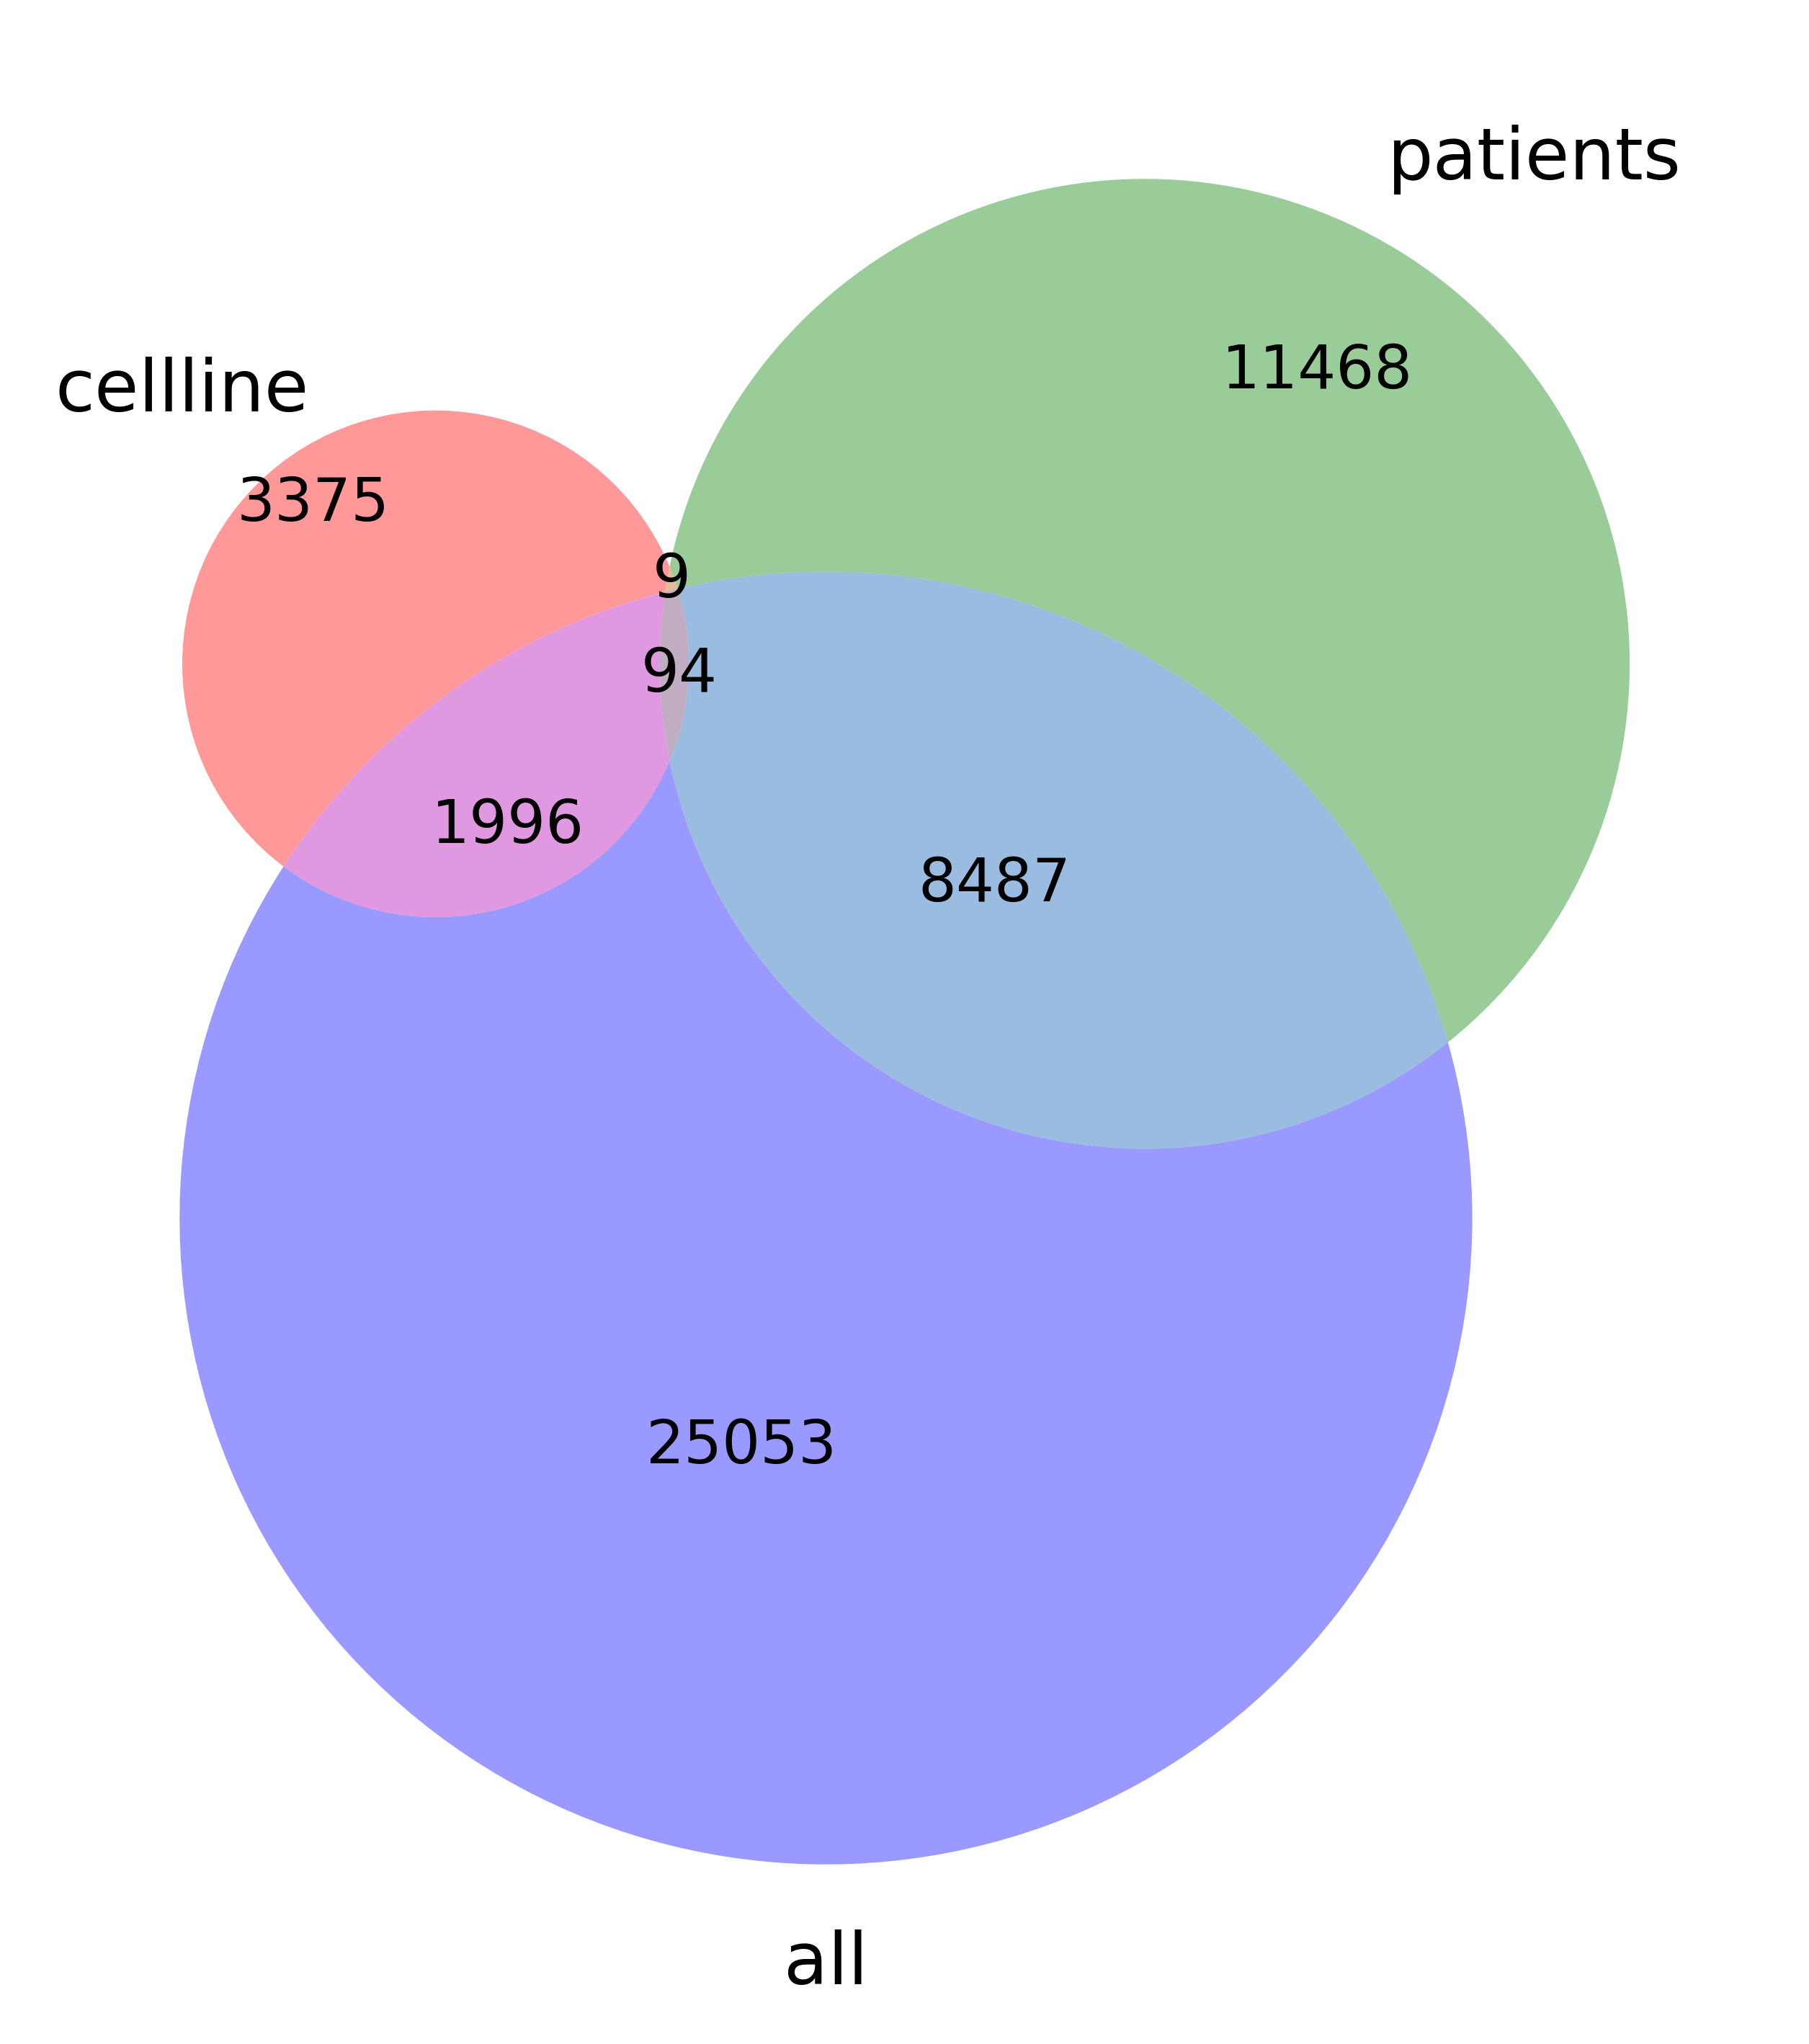

In [101]:
venn3(subsets = (len(only_cellline), len(only_patients), len(two_cellline__patients), 
                 len(only_all),len(two_all__cellline),
                 len(two_all__patients),len(all_all)),
      set_labels = ('cellline', 'patients', 'all'))

In [108]:
# filter furthur
pair_cellline_filtered = set()
for i in only_cellline:
    gene_id = i.split('____')[0]
    snv_id = i.split('____')[1]
    df_tmp = pd.DataFrame({'gene':gene_cellline.loc[gene_id,:],'snv':snv_cellline.loc[snv_id,:]})
    if((df_tmp[df_tmp.gene > 0].snv.value_counts() >20).sum() == 2):
        pair_cellline_filtered.add(i)

# filter furthur
pair_patients_filtered = set()
for i in only_patients:
    gene_id = i.split('____')[0]
    snv_id = i.split('____')[1]
    df_tmp = pd.DataFrame({'gene':gene_patients.loc[gene_id,:],'snv':snv_patients.loc[snv_id,:]})
    if((df_tmp[df_tmp.gene > 0].snv.value_counts() >20).sum() == 2):
        pair_patients_filtered.add(i)

# filter furthur
pair_all_filtered = set()
for i in only_all:
    gene_id = i.split('____')[0]
    snv_id = i.split('____')[1]
    df_tmp = pd.DataFrame({'gene':gene_all.loc[gene_id,:],'snv':snv_all.loc[snv_id,:]})
    if((df_tmp[df_tmp.gene > 0].snv.value_counts() >20).sum() == 2):
        pair_all_filtered.add(i)


In [109]:
len(pair_cellline_filtered)

1746

In [110]:
# only
only_all_filtered = pair_all_filtered - pair_patients_filtered - pair_cellline_filtered 
only_patients_filtered = pair_patients_filtered -  pair_cellline_filtered - pair_all_filtered
only_cellline_filtered = pair_cellline_filtered -  pair_patients_filtered - pair_all_filtered
# all
all_all_filtered = pair_all_filtered.intersection(pair_patients_filtered).intersection(pair_cellline_filtered)
# two
two_all__patients_filtered = pair_all_filtered.intersection(pair_patients_filtered) - all_all_filtered
two_all__cellline_filtered = pair_all_filtered.intersection(pair_cellline_filtered) - all_all_filtered
two_patients__cellline_filtered = pair_patients_filtered.intersection(pair_cellline_filtered) - all_all_filtered

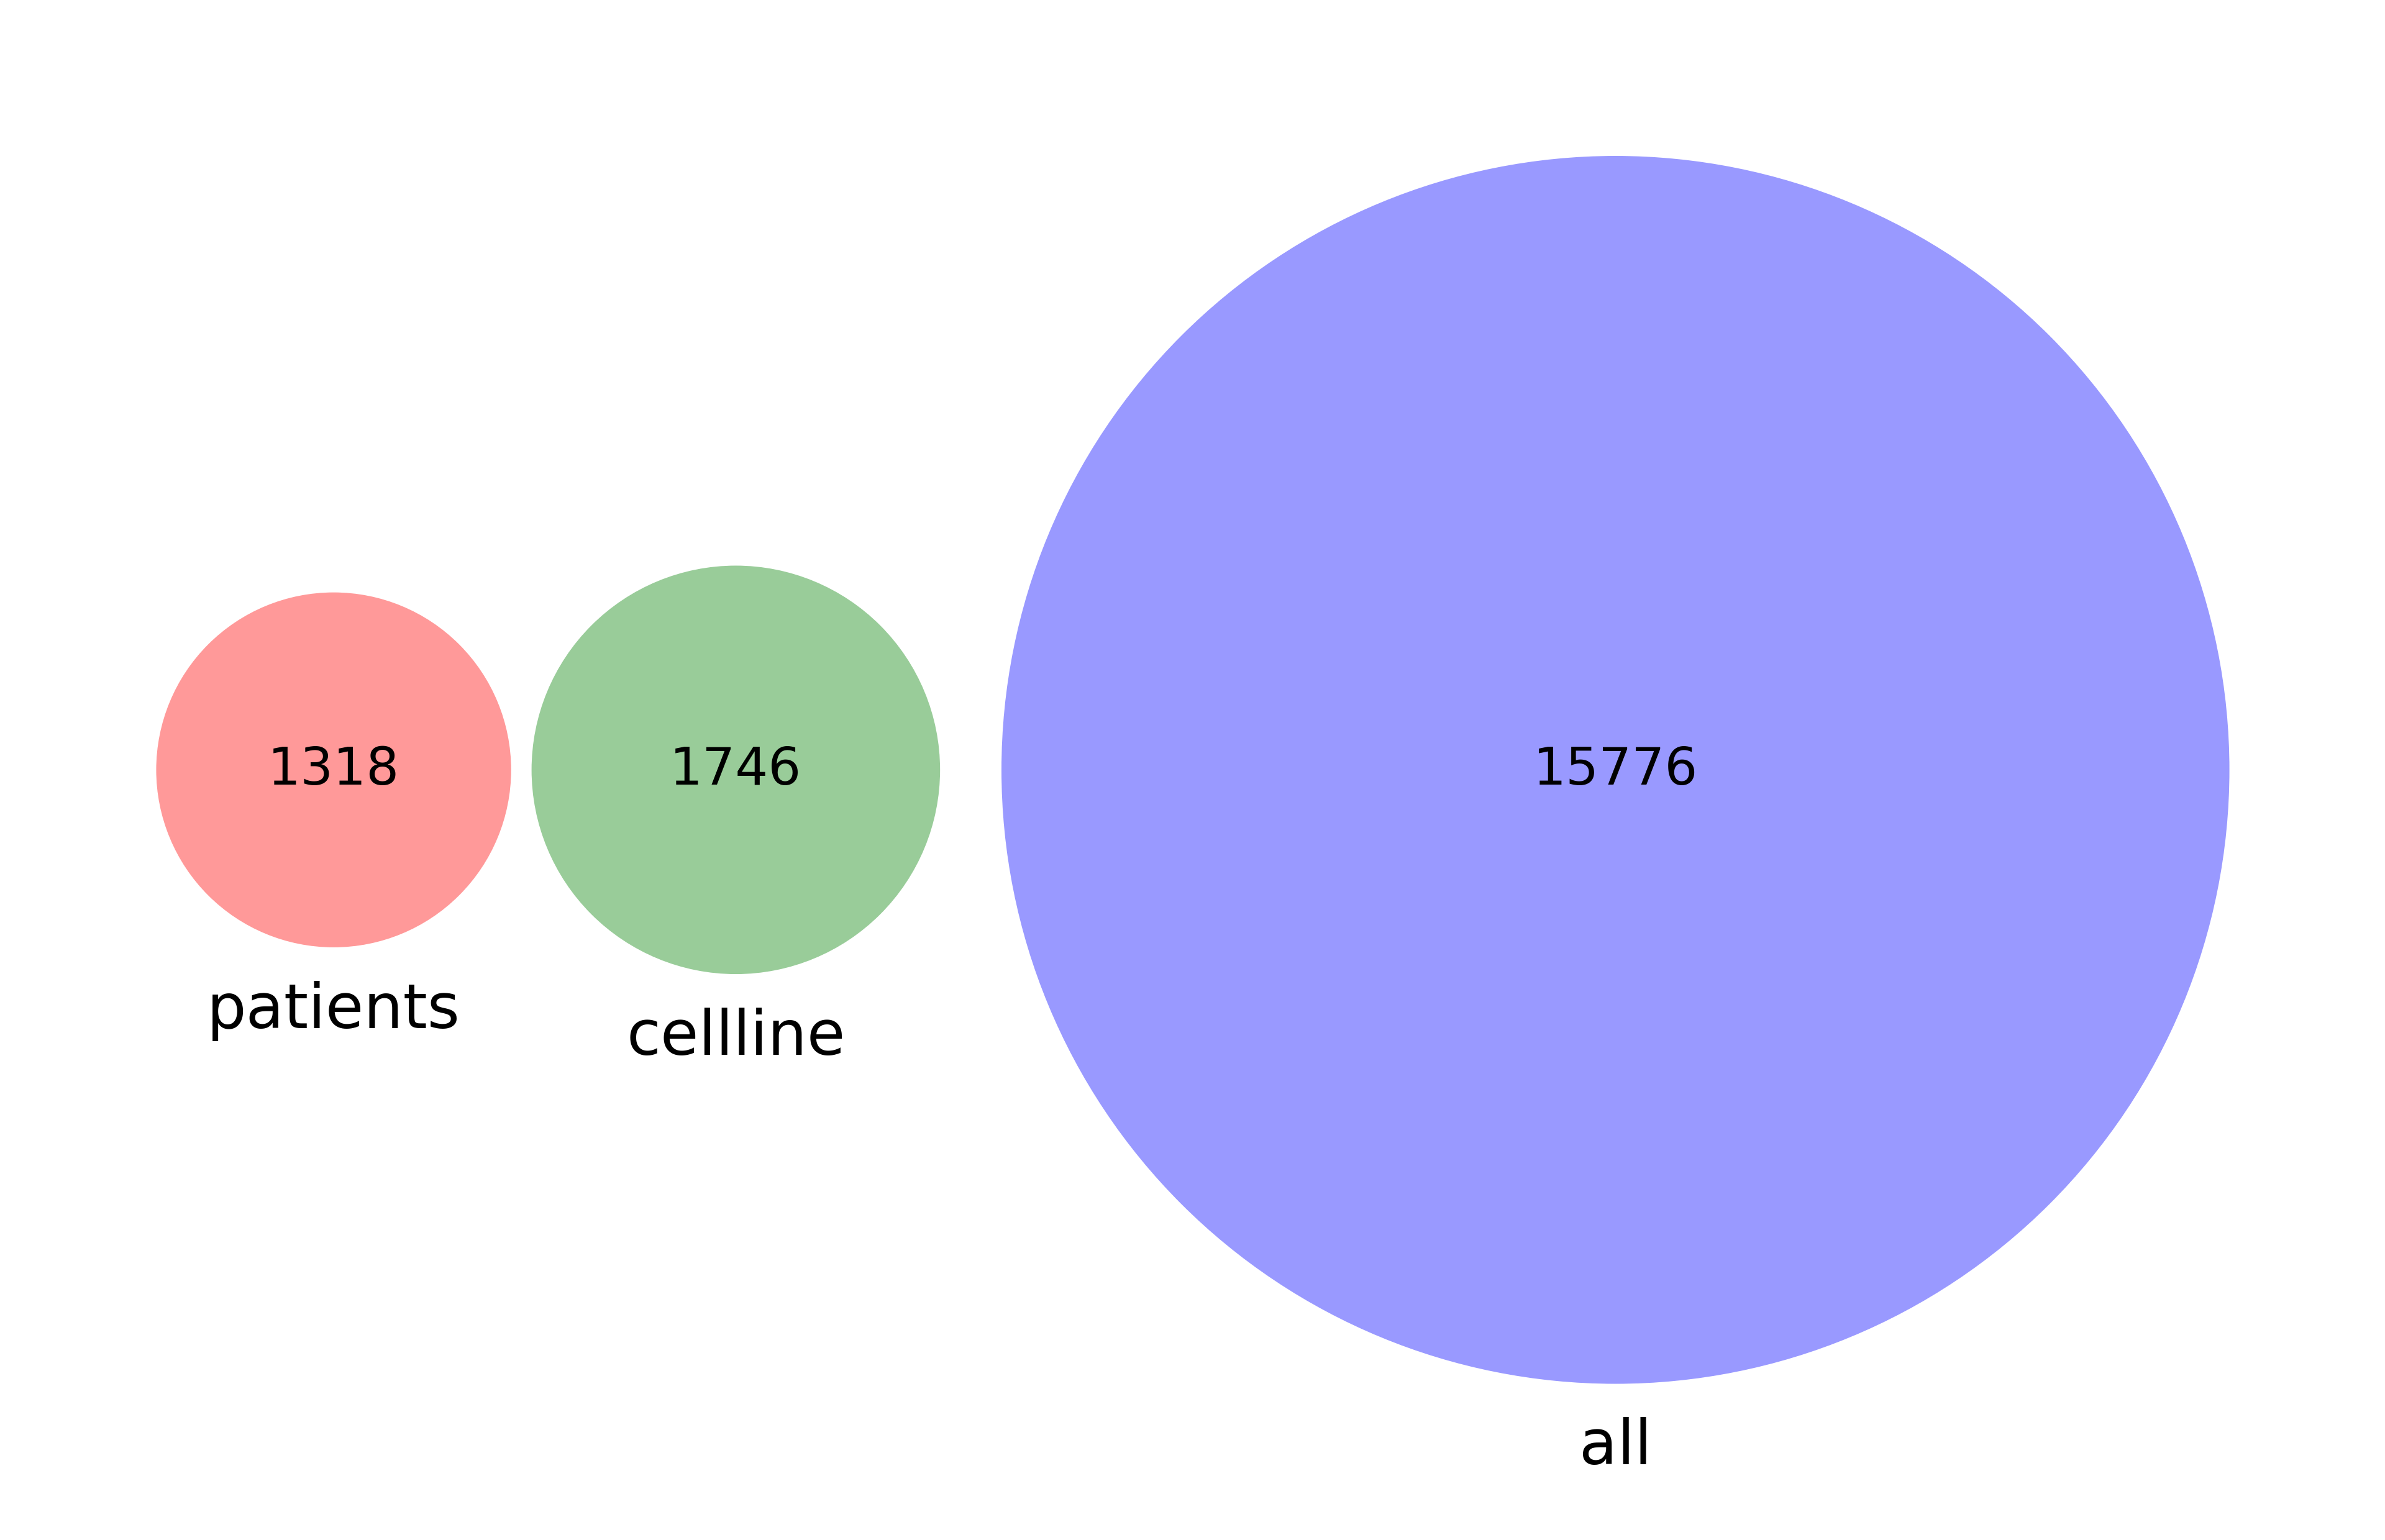

In [111]:
venn3(subsets = (len(only_patients_filtered), len(only_cellline_filtered), len(two_patients__cellline_filtered), 
                 len(only_all_filtered),len(two_all__patients_filtered),
                 len(two_all__cellline_filtered),len(all_all_filtered)),
      set_labels = ('patients', 'cellline', 'all'))